In [1]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
!pip install --upgrade pandas


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 43.45,
	"longitude": -80.48,
	"start_date": "2022-01-01",
	"end_date": "2022-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m", "surface_pressure", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_direction_100m = hourly.Variables(6).ValuesAsNumpy()

'''hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}'''

hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True) - pd.Timedelta(seconds=1),  # Adjust end time
        freq=pd.Timedelta(seconds=hourly.Interval())
    )
}


hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_direction_100m"] = hourly_wind_direction_100m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)


/home/npacey/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/npacey/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Coordinates 43.47978591918945°N -80.54055786132812°E
Elevation 342.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                          date  temperature_2m  relative_humidity_2m  \
0    2022-01-01 00:00:00+00:00          0.5325             98.565163   
1    2022-01-01 01:00:00+00:00          0.9825             97.862434   
2    2022-01-01 02:00:00+00:00          0.5825             97.502060   
3    2022-01-01 03:00:00+00:00          1.7825             95.792526   
4    2022-01-01 04:00:00+00:00          2.1825             94.782127   
...                        ...             ...                   ...   
8755 2022-12-31 19:00:00+00:00          6.0325             98.627426   
8756 2022-12-31 20:00:00+00:00          6.4825             97.617462   
8757 2022-12-31 21:00:00+00:00          5.7825             98.283478   
8758 2022-12-31 22:00:00+00:00          5.1825             97.253044   
8759 2022-12-31 23:00:00+00:00          4.5825             97.581184   

      su

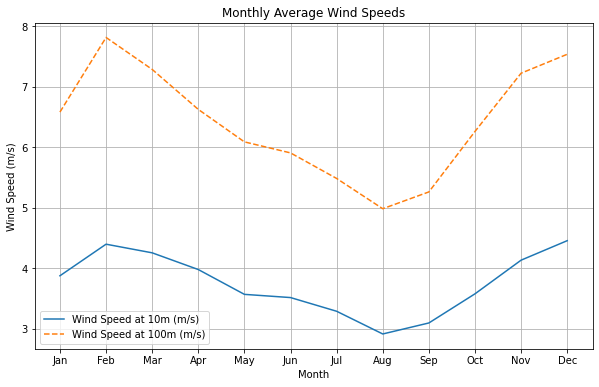

In [3]:
# Convert wind speeds from km/h to m/s
hourly_data["wind_speed_10m"] = hourly_data["wind_speed_10m"] / 3.6
hourly_data["wind_speed_100m"] = hourly_data["wind_speed_100m"] / 3.6

# Add the converted wind speeds to the DataFrame
hourly_dataframe = pd.DataFrame(data=hourly_data)

# Convert 'date' to a datetime index in the DataFrame
hourly_dataframe.set_index('date', inplace=True)

# Plotting wind speeds for each month
import matplotlib.pyplot as plt

# Extract month from the index (date)
hourly_dataframe['month'] = hourly_dataframe.index.month

# Group by month and calculate the mean wind speed for plotting
monthly_wind_speed_10m = hourly_dataframe.groupby('month')['wind_speed_10m'].mean()
monthly_wind_speed_100m = hourly_dataframe.groupby('month')['wind_speed_100m'].mean()

# Plotting
plt.figure(figsize=(10, 6))
monthly_wind_speed_10m.plot(label='Wind Speed at 10m (m/s)')
monthly_wind_speed_100m.plot(label='Wind Speed at 100m (m/s)', linestyle='--')
plt.title('Monthly Average Wind Speeds')
plt.xlabel('Month')
plt.ylabel('Wind Speed (m/s)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()


/home/npacey/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


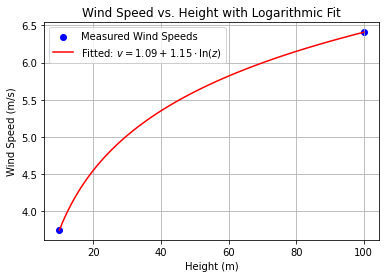

In [4]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Heights and average wind speeds
heights = np.array([10, 100])  # Heights in meters
average_wind_speeds = np.array([
    np.mean(hourly_data["wind_speed_10m"]),
    np.mean(hourly_data["wind_speed_100m"])
])

# Define the logarithmic wind profile function
def log_wind_profile(z, a, b):
    return a + b * np.log(z)

# Attempt to fit the curve
# Note: With only two data points, this is more of a demonstration than a robust fit.
try:
    popt, pcov = curve_fit(log_wind_profile, heights, average_wind_speeds)
    
    # Generate heights for the fitted curve visualization
    fitted_heights = np.linspace(10, 100, 100)  # From 10m to 100m
    fitted_speeds = log_wind_profile(fitted_heights, *popt)
    
    # Plotting the original data and the fitted curve
    plt.scatter(heights, average_wind_speeds, color='blue', label='Measured Wind Speeds')
    plt.plot(fitted_heights, fitted_speeds, 'r-', label=f'Fitted: $v = {popt[0]:.2f} + {popt[1]:.2f} \cdot \ln(z)$')
    plt.title('Wind Speed vs. Height with Logarithmic Fit')
    plt.xlabel('Height (m)')
    plt.ylabel('Wind Speed (m/s)')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print("An error occurred during curve fitting:", e)

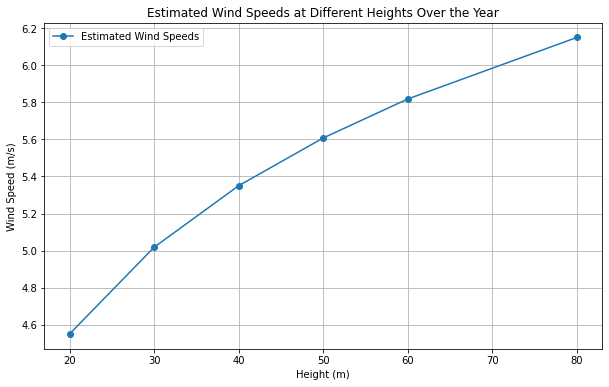

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the curve fit parameters 'a' and 'b' were obtained as described previously
# Example parameters (replace with actual fitted values)
a, b = popt[0], popt[1]



# Heights for which we want to estimate wind speeds based on the fitted curve
estimated_heights = np.array([20, 30, 40, 50, 60, 80])

# Generate wind speeds for these heights using the fitted equation
estimated_wind_speeds = log_wind_profile(estimated_heights, a, b)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(estimated_heights, estimated_wind_speeds, 'o-', label='Estimated Wind Speeds')

plt.title('Estimated Wind Speeds at Different Heights Over the Year')
plt.xlabel('Height (m)')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
import numpy as np
from scipy.optimize import curve_fit

# Sample wind speeds at 10m and 100m for demonstration
# These should be replaced with your actual data arrays
wind_speed_10m = hourly_data["wind_speed_10m"]
wind_speed_100m = hourly_data["wind_speed_100m"]

# Define the heights for the wind speeds we have and the ones we want to interpolate
measured_heights = np.array([10, 100])
interpolate_heights = np.array([20, 30, 40, 50, 60, 80])

# Define the logarithmic wind profile function
def log_wind_profile(z, a, b):
    return a + b * np.log(z)

# Initialize a dictionary to store interpolated speeds
interpolated_speeds = {f'wind_speed_{h}m': [] for h in interpolate_heights}

# Iterate over each hour
for i in range(len(wind_speed_10m)):
    # Current wind speeds at 10m and 100m for the hour
    current_speeds = np.array([wind_speed_10m[i], wind_speed_100m[i]])
    
    # Fit the curve for this hour's data
    popt, _ = curve_fit(log_wind_profile, measured_heights, current_speeds)
    
    # Use the obtained fit to calculate speeds at desired heights
    for h in interpolate_heights:
        interpolated_speed = log_wind_profile(h, *popt)
        interpolated_speeds[f'wind_speed_{h}m'].append(interpolated_speed)

# After looping through all hours, interpolated_speeds will contain the estimated speeds for each height


In [23]:
for height, speeds in interpolated_speeds.items():
    hourly_data[height] = speeds

# Convert hourly_data to a DataFrame
hourly_dataframe = pd.DataFrame(data=hourly_data)
hourly_dataframe

,date,temperature_2m,relative_humidity_2m,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_speed_20m,wind_speed_30m,wind_speed_50m,wind_speed_60m,wind_speed_80m,wind_speed_40m
0,2022-01-01 00:00:00+00:00,0.5325,98.565163,967.477722,1.649242,2.529822,75.963730,108.435043,1.914323,2.069386,2.264741,2.334467,2.444485,2.179404
1,2022-01-01 01:00:00+00:00,0.9825,97.862434,967.065857,2.009975,4.080441,95.710503,126.027466,2.633248,2.997838,3.457169,3.621111,3.879792,3.256520
2,2022-01-01 02:00:00+00:00,0.5825,97.502060,966.527100,2.195450,4.920366,120.068497,142.431335,3.015731,3.495565,4.100084,4.315847,4.656294,3.836013
3,2022-01-01 03:00:00+00:00,1.7825,95.792526,966.130554,2.154066,4.609772,111.801476,139.398788,2.893307,3.325735,3.870531,4.064976,4.371789,3.632548
4,2022-01-01 04:00:00+00:00,2.1825,94.782127,966.285583,1.562050,4.318565,129.805527,137.815628,2.391844,2.877242,3.488771,3.707036,4.051431,3.221637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00+00:00,6.0325,98.627426,966.846558,1.303840,3.301515,265.601379,271.735657,1.905200,2.256973,2.700155,2.858333,3.107920,2.506560
8756,2022-12-31 20:00:00+00:00,6.4825,97.617462,966.815430,1.802776,4.177320,273.179779,281.040894,2.517585,2.935721,3.462511,3.650530,3.947202,3.232394
8757,2022-12-31 21:00:00+00:00,5.7825,98.283478,966.810486,2.912044,5.727128,285.945465,294.775116,3.759469,4.255180,4.879703,5.102605,5.454318,4.606893
8758,2022-12-31 22:00:00+00:00,5.1825,97.253044,967.587341,3.498571,6.780118,300.963684,307.208008,4.486415,5.064267,5.792274,6.052111,6.462103,5.474259


In [26]:
# Check if 'date' is already the index or a column in the DataFrame
if 'date' in hourly_dataframe.columns:
    # Convert 'date' column to datetime if it exists as a column
    hourly_dataframe['date'] = pd.to_datetime(hourly_dataframe['date'])
    # Set 'date' as the DataFrame index
    hourly_dataframe.set_index('date', inplace=True)
elif not isinstance(hourly_dataframe.index, pd.DatetimeIndex):
    # If 'date' is not a column and the index is not already a DatetimeIndex, attempt conversion
    hourly_dataframe.index = pd.to_datetime(hourly_dataframe.index)

# Filter the DataFrame for January
january_data = hourly_dataframe[hourly_dataframe.index.month == 1]


,temperature_2m,relative_humidity_2m,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_speed_20m,wind_speed_30m,wind_speed_50m,wind_speed_60m,wind_speed_80m,wind_speed_40m
date,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,0.5325,98.565163,967.477722,1.649242,2.529822,75.963730,108.435043,1.914323,2.069386,2.264741,2.334467,2.444485,2.179404
2022-01-01 01:00:00+00:00,0.9825,97.862434,967.065857,2.009975,4.080441,95.710503,126.027466,2.633248,2.997838,3.457169,3.621111,3.879792,3.256520
2022-01-01 02:00:00+00:00,0.5825,97.502060,966.527100,2.195450,4.920366,120.068497,142.431335,3.015731,3.495565,4.100084,4.315847,4.656294,3.836013
2022-01-01 03:00:00+00:00,1.7825,95.792526,966.130554,2.154066,4.609772,111.801476,139.398788,2.893307,3.325735,3.870531,4.064976,4.371789,3.632548
2022-01-01 04:00:00+00:00,2.1825,94.782127,966.285583,1.562050,4.318565,129.805527,137.815628,2.391844,2.877242,3.488771,3.707036,4.051431,3.221637
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31 19:00:00+00:00,-2.7175,62.130768,981.737122,2.418677,3.733631,187.124924,187.695953,2.814518,3.046070,3.337790,3.441910,3.606199,3.210358
2022-01-31 20:00:00+00:00,-2.6675,62.143238,981.936401,2.061553,3.420526,194.036270,195.255173,2.470644,2.709948,3.011434,3.119040,3.288828,2.879736
2022-01-31 21:00:00+00:00,-2.7675,63.343578,982.016724,1.503330,2.828427,183.813995,188.130020,1.902224,2.135562,2.429533,2.534456,2.700012,2.301118


<Figure size 1080x576 with 0 Axes>

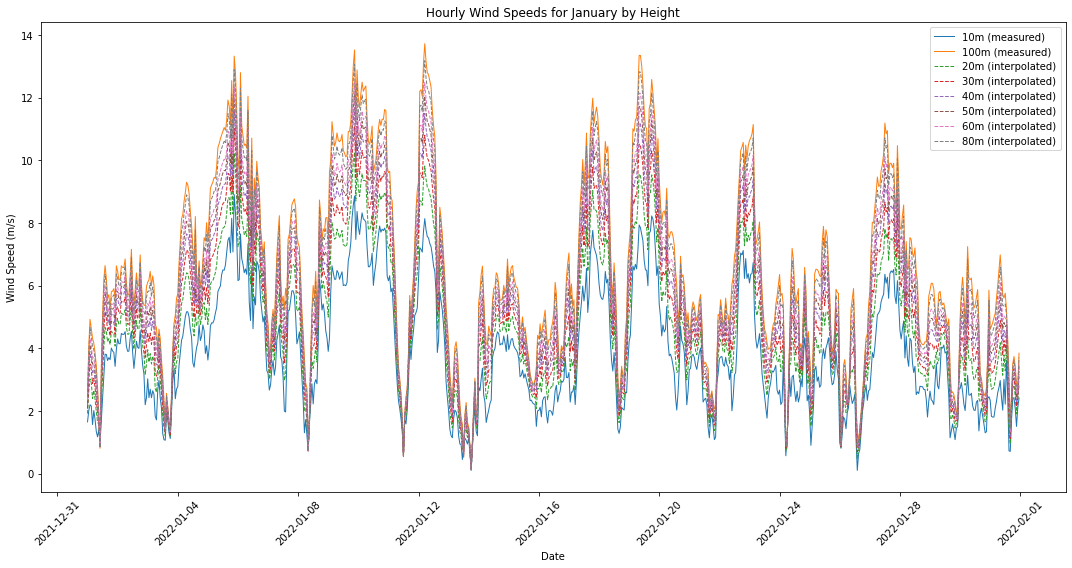

In [29]:
import matplotlib.pyplot as plt

# Plotting wind speeds for January
plt.figure(figsize=(15, 8))

# Ensure january_data's index and relevant columns are in a compatible format
dates = january_data.index.to_pydatetime()  # Convert index to pydatetime for compatibility
wind_speed_10m = january_data['wind_speed_10m'].to_numpy()  # Convert to numpy array
wind_speed_100m = january_data['wind_speed_100m'].to_numpy()  # Convert to numpy array

plt.figure(figsize=(15, 8))

# Plotting with explicit numpy arrays
plt.plot(dates, wind_speed_10m, label='10m (measured)', markersize=3, linestyle='-', linewidth=1)
plt.plot(dates, wind_speed_100m, label='100m (measured)', markersize=3, linestyle='-', linewidth=1)

# Interpolated wind speeds plotting
for height in ['20m', '30m', '40m', '50m', '60m', '80m']:
    speed_array = january_data[f'wind_speed_{height}'].to_numpy()  # Ensuring conversion to numpy array
    plt.plot(dates, speed_array, label=f'{height} (interpolated)', linestyle='--', linewidth=1)

plt.title('Hourly Wind Speeds for January by Height')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend(loc='upper right')
plt.xticks(rotation=45)

# To improve the readability of the x-axis, consider setting a formatter or locator
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Optional: Adjust the number of x-axis labels

plt.tight_layout()
plt.show()